In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from ipywidgets import interact, widgets
from IPython.display import display

In [2]:
# Imports the csv into a panda dataframe



df = pd.read_csv('C:/Users/Corey/Desktop/C964/spam.csv')

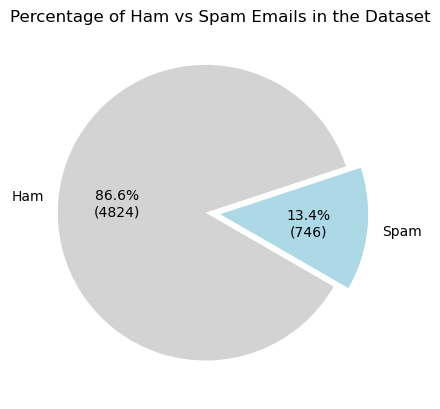

In [3]:
# Creates a pie chart showing percentage of spam and ham and their count



email_count = [(df[df['Category'] == 'spam']['Message']).size, df[df['Category'] == 'ham']['Message'].size]
email_type = ['Spam', 'Ham']


def percent_value(pct, value):
    absolute = int(pct / 100.*np.sum(value))
    return"{:.1f}%\n({:d})".format(pct, absolute)


plt.pie(email_count, labels=email_type, autopct=lambda pct: percent_value(pct, email_count), startangle=330,
        colors=['LightBlue', 'LightGrey'], explode=[0, 0.1], )
plt.title("Percentage of Ham vs Spam Emails in the Dataset")
plt.show()

In [4]:
# Cleans the data and gets it ready for use



stop_words = stopwords.words('english')

def word_cleaner(message, stemming_flag=False, Lemmatisation_flag=False, stop_words=None):
    # Makes All Words lowercase
    message = str(message).lower()
    # Removes Whitespaces
    message = str.strip(message)
    # Strips Punctuation
    message = re.sub(r'[^\w\s]', '', message)
    # Tokenize(Converts String to List)
    message_lst = word_tokenize(message)
    # Remove Stopwords
    if message_lst is not None:
        message_lst = [word for word in message_lst if word not in stop_words]
    # Stemming (removing ing, ly, etc...)
    if stemming_flag:
        ps = PorterStemmer()
        message_lst = [ps.stem(word) for word in message_lst]
    # Lemmatisation (convert into root word)
    if Lemmatisation_flag:
        lem = WordNetLemmatizer()
        message_lst = [lem.lemmatize(word) for word in message_lst]
    # Converts back to sting from list
    message = " ".join(message_lst)
    return message

#Applies the function to all the data in the Message dataframe and saves it on new Dataframe

df['cleaned_text'] = df['Message'].apply(lambda message: word_cleaner(message, stop_words=stop_words))

Text(0.5, 0, 'Words')

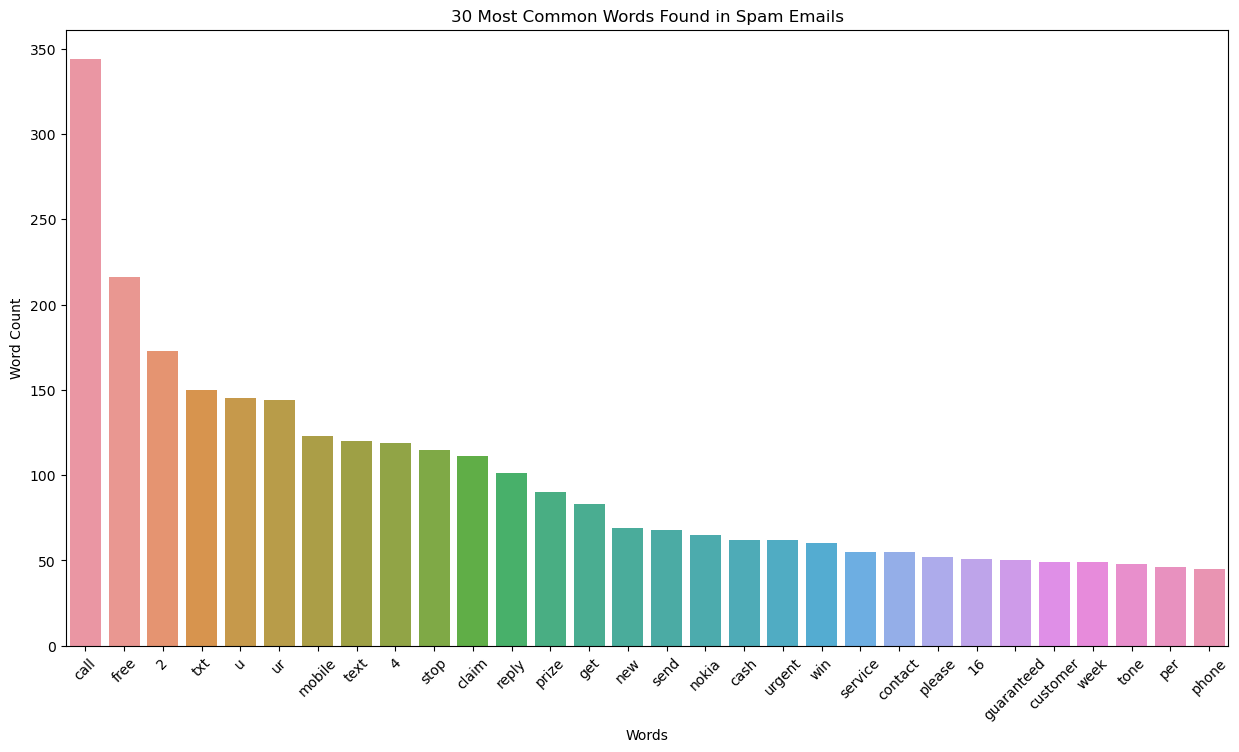

In [5]:
# Shows the 30 most common words found in the Ham Emails in a barplot



spam_corpus = []
for mail in df[df['Category'] == 'spam']['cleaned_text'].tolist():
    for word in mail.split():
        spam_corpus.append(word)

        
plt.figure(figsize=(15, 8))
plt.title('30 Most Common Words Found in Spam Emails')
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation=45)
plt.ylabel('Word Count')
plt.xlabel('Words')


Text(0.5, 0, 'Words')

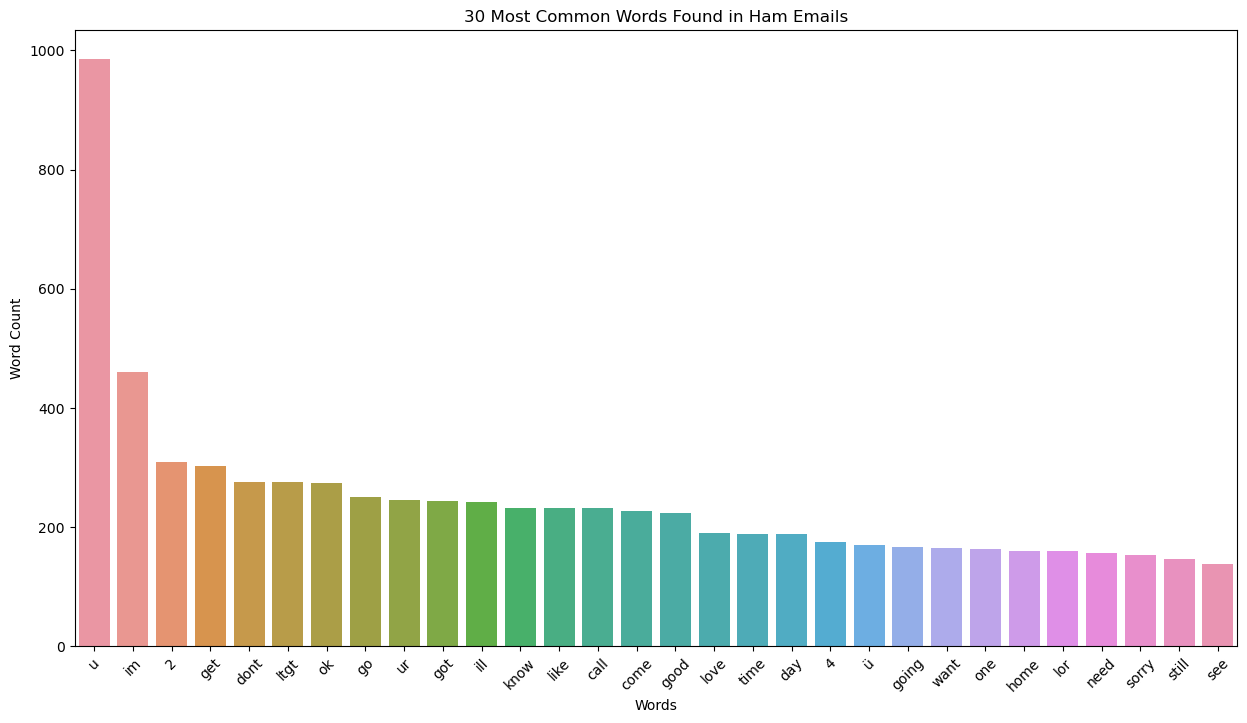

In [6]:
# Shows the 30 most common words found in the Ham Emails in a barplot

ham_corpus = []
for mail in df[df['Category'] == 'ham']['cleaned_text'].tolist():
    for word in mail.split():
        ham_corpus.append(word)

plt.figure(figsize=(15, 8))
plt.title('30 Most Common Words Found in Ham Emails')
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation=45)
plt.ylabel('Word Count')
plt.xlabel('Words')


In [7]:
# Splits the data into 2 categories for the optimization algorithm
# Training Data and Testing Data



encoder = LabelEncoder()
encoder.fit(df['Category'])
df['Category'] = encoder.transform(df['Category'])
x = df['cleaned_text']
y = df['Category'].values

vec = TfidfVectorizer(max_features=15000, ngram_range=(1, 2))
x = vec.fit_transform(x).toarray()

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.3, random_state=42)

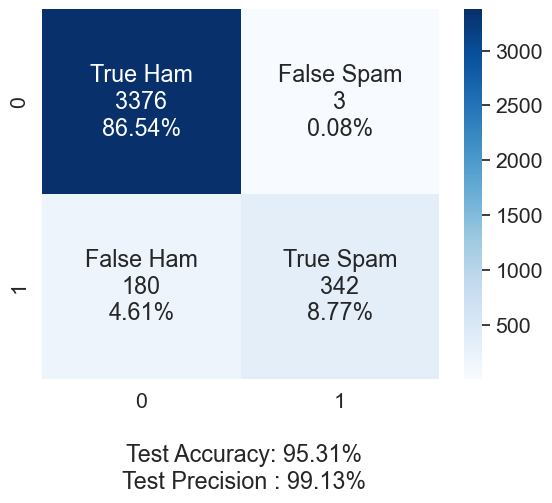

In [8]:
# Runs the SGD optimizer algorithm with 2 hidden layers



# The Attributes of the model are saved in spamFilterModel folder
# This is a reproduction of the code used to train to model

# opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
# model = Sequential()
# model.add(Dropout(0.3))
# model.add(Dense(64, activation=tf.nn.relu))
# model.add(Dropout(0.4))
# model.add(Dense(32, activation=tf.nn.relu))
# model.add(Dense(1, activation=tf.nn.sigmoid))
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=250, verbose=2)

# Loads up the saved model

trained_model = keras.models.load_model('C:/Users/Corey/Desktop/pythonProject\spamFilterModel')

# Gets the prediction of the test data using the model

prediction = trained_model.predict(x_test, verbose=0)
prediction = prediction.flatten()
y_prediction = np.where(prediction >= 0.5, 1, 0)

# Creates a confusion matrix showing the True Ham, False Spam, False Ham, and True Spam

cf = confusion_matrix(y_test, y_prediction)
heatmap_names = ['True Ham', 'False Spam', 'False Ham', 'True Spam']
heatmap_count = ["{0:0.0f}".format(value) for value in cf.flatten()]
heatmap_percentage = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
heatmap_labels = [f"{var1}\n{var2}\n{var3}" for var1, var2, var3 in
                    zip(heatmap_names, heatmap_count, heatmap_percentage)]
heatmap_labels = np.asarray(heatmap_labels).reshape(2, 2)
sns.set(font_scale=1.4)
sns.heatmap(cf, annot=heatmap_labels, fmt='', cmap='Blues')
test_acc = accuracy_score(y_test, y_prediction)
test_precision = precision_score(y_test, y_prediction)
plt.xlabel('\n Test Accuracy: ' + "{0:.2%}".format(test_acc)
          + '\n Test Precision : ' + "{0:.2%}".format(test_precision))

plt.show()




In [9]:


message = widgets.Textarea(
    placeholder='Enter the email here!',
    description='Checker',
    disabled=False
)

# An interactive textarea for the end user to input an email and will display if the email is spam or ham

display(message)
btn=widgets.Button(description="Submit")
display(btn)
lbl = widgets.Label()
display(lbl)
def spam_checker(m):
    m = [message.value]
    if message.value==0:
        lbl.value="Please enter an email to check"
       
    else:
        m = [word_cleaner(m, stop_words=stop_words)]
        vect = vec.transform(m).toarray()
        sh_prediction = trained_model.predict(vect, verbose=0)
        sh_prediction = sh_prediction.flatten()
        spam_ham_actual = np.where(sh_prediction >= 0.5, 1, 0)
        if spam_ham_actual == 0:
            lbl.value=("This is not Spam")
        else:
            lbl.value=("This is Spam")
btn.on_click(spam_checker)

Textarea(value='', description='Checker', placeholder='Enter the email here!')

Button(description='Submit', style=ButtonStyle())

Label(value='')